In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from vrae.vrae import VRAE
from vrae.utils_VAE import *
from vrae.utils_GMM import *
from vrae.post_gmm_merging import *
from annotation_parsers import dump_labels_bento
import numpy as np
import torch
import pickle

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error as mse

import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

%load_ext autoreload
%autoreload 2

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from seaborn import clustermap

In [2]:
dload = './model_dir'

### Loading model, data, etc

In [3]:
seq_len = 10
hidden_size = 256
hidden_layer_depth = 3
latent_length = 16
batch_size = 32
learning_rate = 0.00002
n_epochs = 300
dropout_rate = 0.0
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every = 10
val_every = 1000
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU
output = False
reduction = 'mean'

In [4]:
all_file = ['20201020_Pop_Cage_001','20201020_Pop_Cage_002','20201020_Pop_Cage_003','20201020_Pop_Cage_004',
                 '20201020_Pop_Cage_005','20201020_Pop_Cage_006','20201020_Pop_Cage_007']
X_all, y_all = load_data(direc = 'data', dataset="EMG", all_file = all_file,
                         do_pca = False, single_channel = None, 
                         batch_size = batch_size, seq_len = seq_len, pca_component = 6)
all_dataset = TensorDataset(torch.from_numpy(X_all))

Loading 20201020_Pop_Cage_001, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.]
Loading 20201020_Pop_Cage_002, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.]
Loading 20201020_Pop_Cage_003, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_004, X shape (3601, 150, 1), y shape (3601, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_005, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  5.]
Loading 20201020_Pop_Cage_006, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_007, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Dataset shape: (25184, 10, 15)
Label: [-1.  0.  1.  2.  3.  4.  5.], shape: (25184, 1)


In [10]:
num_features = X_all.shape[2]

In [166]:
from vrae.vrae import VRAE
vrae = VRAE(sequence_length=seq_len,
            number_of_features = num_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload,
            output = output,
            reduction = reduction)

In [167]:
vrae.load(dload+'/vrae_b32_z16_300epoch.pth')

In [6]:
with open(dload+'/vrae_b32_z8_mean_350epoch.pth', 'rb') as fh:
    vrae = pickle.load(fh)

In [7]:
z_run = vrae.transform(all_dataset)

/home/roton2/miniconda3/envs/emg/lib/python3.9/site-packages/torch/nn/modules/rnn.py:679: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630841592/work/aten/src/ATen/native/cudnn/RNN.cpp:924.)



In [8]:
bhvs = {'no_behavior': np.array([-1]), 
        'crawling': np.array([0]),
        'high picking treats': np.array([1]),
        'low picking treats': np.array([2]),
        'pg': np.array([3]),
        'sitting still': np.array([4]),
        'grooming': np.array([5])}

inv_bhvs = {int(v): k for k, v in bhvs.items()}

# visualize(z_run = z_run, y = y_all, inv_bhvs = inv_bhvs, one_in = 4)

In [282]:
with open(dload+'/gmm_label_b32_z16', "wb") as fh:
    pickle.dump(gmm_labels, fh)

### Choose number of mixture components

In [237]:
for ii in range(8):
    all_bic, all_bic_err, n_cluster, gmm_labels = gmm_bic(z_run, [20, 60], num_iteration = 5, 
                                                          fit = False, plot = False)

Number of clusters: 55.
Number of clusters not found, use 55.
Number of clusters not found, use 60.
Number of clusters not found, use 56.
Number of clusters: 53.
Number of clusters: 55.
Number of clusters not found, use 55.
Number of clusters not found, use 59.
Number of clusters: 48.
Number of clusters: 52.


Before merge: 100 clusters, after merge 17 times: 83 clusters.


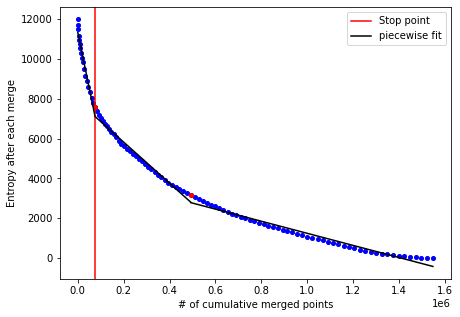

In [34]:
merge_info, gmm_labels, merged_labels, gmm_prob, merged_prob, merge_matrix = merge_gmm(z_run, n_components = 100, 
                                                    stop_method = 'piecewise', piecewise_components=3, stop_at = 1)

### PCA

In [ ]:
all_file = ['20201020_Pop_Cage_001','20201020_Pop_Cage_002','20201020_Pop_Cage_003','20201020_Pop_Cage_004',
                 '20201020_Pop_Cage_005','20201020_Pop_Cage_006','20201020_Pop_Cage_007']
X_all, y_all = load_data(direc = 'data', dataset="EMG", all_file = all_file,
                         do_pca = False, single_channel = None, 
                         batch_size = batch_size, seq_len = seq_len, pca_component = 6)
all_dataset = TensorDataset(torch.from_numpy(X_all))

Explained variance ratio: [0.4588054  0.59680276 0.65144796 0.70225438 0.74233446 0.77040076
 0.79390788 0.81280353 0.82558417 0.83727956 0.84753524 0.85637753
 0.86491355 0.87230623 0.87897648 0.8849853  0.89081481 0.8960594
 0.90091851 0.90545415 0.90982324 0.91386458 0.91720056 0.92052325
 0.92366187 0.92677477 0.92985545 0.93273736 0.93545823 0.93813407
 0.94039327 0.94258115 0.94461434 0.94662203 0.94853895 0.95039271
 0.95214905 0.95374032 0.95515785 0.95652886 0.95787435 0.95913442
 0.96031063 0.96142124 0.96249888 0.96356476 0.96451499 0.9654563
 0.96639635 0.96728926 0.96817848 0.96903455 0.96988655 0.97069916
 0.97151058 0.97224156 0.97293722 0.97362904 0.97430132 0.97495151
 0.97559062 0.9762012  0.97680938 0.97740478 0.97797902 0.97854466
 0.97910639 0.97965302 0.98017348 0.98067767 0.98117444 0.98166742
 0.98215526 0.98263298 0.98310395 0.98356387 0.98401831 0.98445778
 0.9848902  0.98531131 0.98572464 0.9861307  0.98652715 0.98691266
 0.98729096 0.98766302 0.98802626 0.98

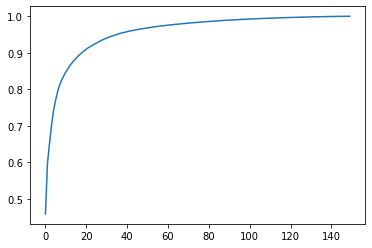

In [332]:
# X_all_cat = X_all.reshape(X_all.shape[0], -1)
# X_pca = PCA(n_components = 19).fit_transform(X_all_cat)

aaaaa = PCA(n_components=X_all_cat.shape[1]).fit(X_all_cat)
print(f'Explained variance ratio: {np.cumsum(aaaaa.explained_variance_ratio_)}')
plt.plot(np.cumsum(aaaaa.explained_variance_ratio_))

Number of clusters: 46.


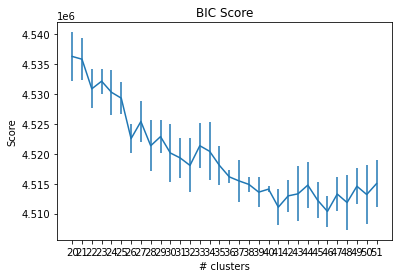

In [342]:
all_bic, all_bic_err, n_cluster_pca, _ = gmm_bic(X_pca, [20, 60], num_iteration = 5, fit = False)

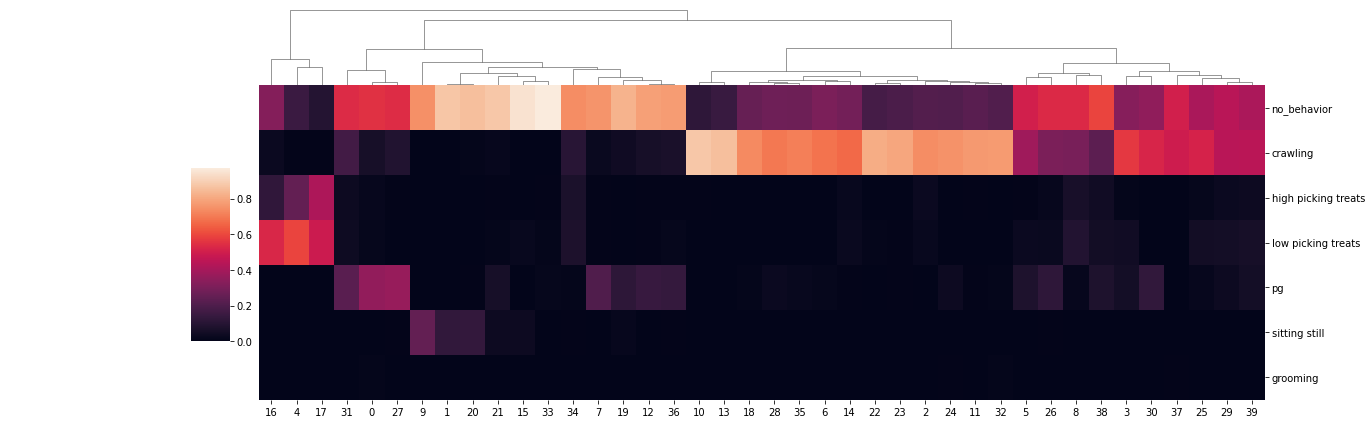

In [291]:
plot_confusion_matrix(y_all, gmm_labels_pca, bhvs.keys(), figsize = (18,6), sum_by = 'col')

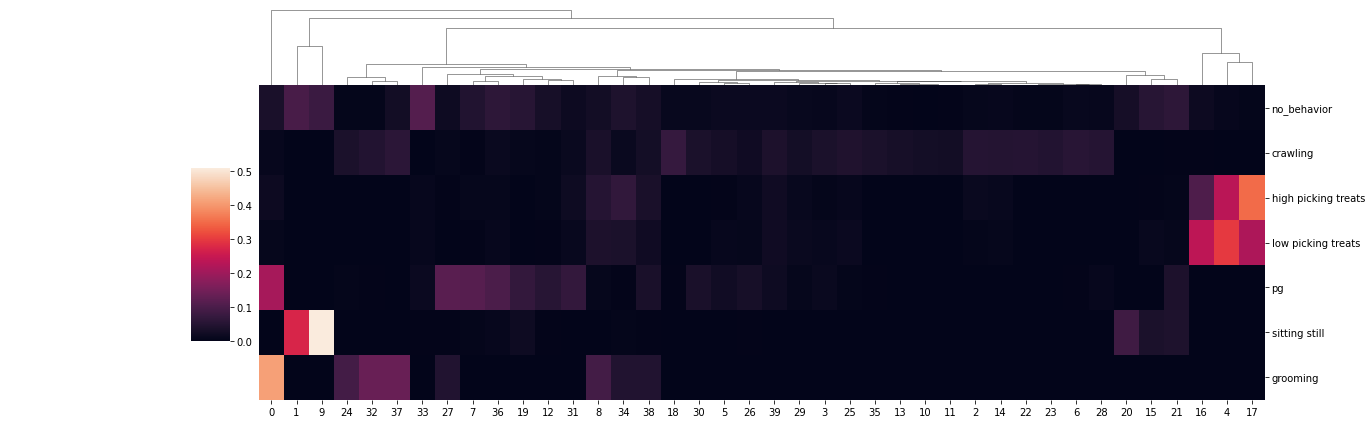

In [292]:
plot_confusion_matrix(y_all, gmm_labels_pca, bhvs.keys(), figsize = (18,6), sum_by = 'row')

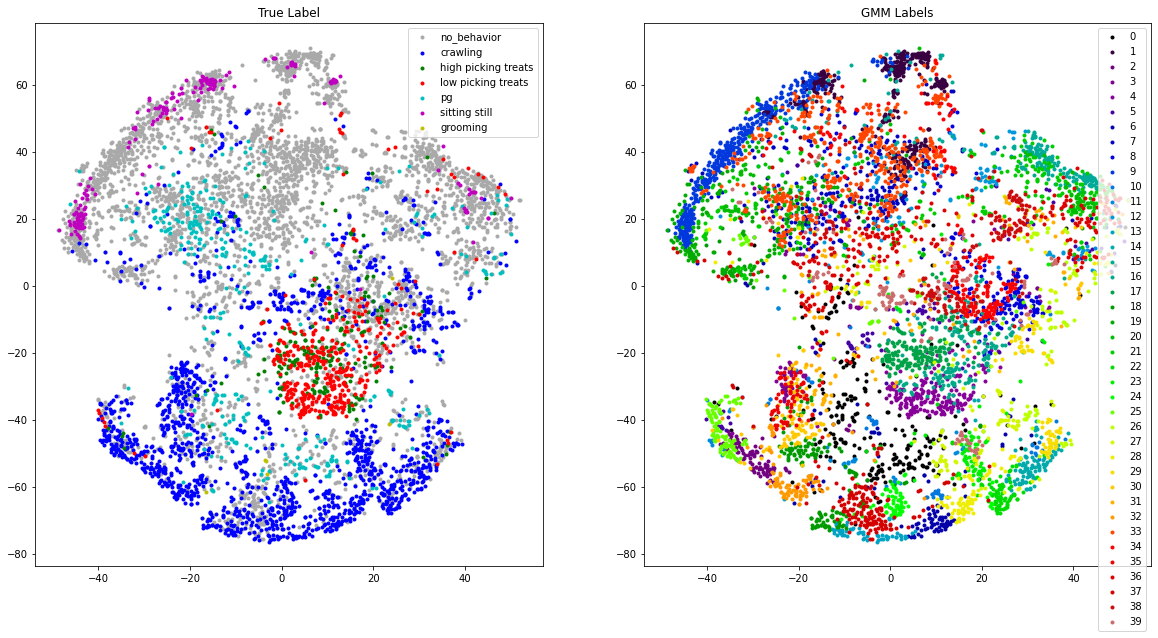

In [311]:
# hex_colors = []
# for _ in np.unique(gmm_labels_pca):
#     hex_colors.append('#%06X' % randint(0, 0xFFFFFF)
# color2 =  ["blue","black","brown","red","yellow","green","orange","dimgray","turquoise","pink"]

compare_label_tSNE(X_pca, y_all, inv_bhvs, 'True Label', gmm_labels_pca, None, 'GMM Labels',
                       one_in = 4, perplexity=80, n_iter=3000)

### z=8 mean

Number of clusters: 48.


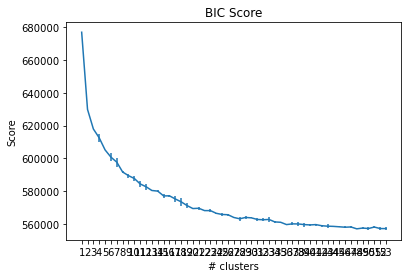

In [353]:
all_bic, all_bic_err, n_cluster, gmm_labels_meanz8 = gmm_bic(z_run, [1,60], num_iteration = 5)

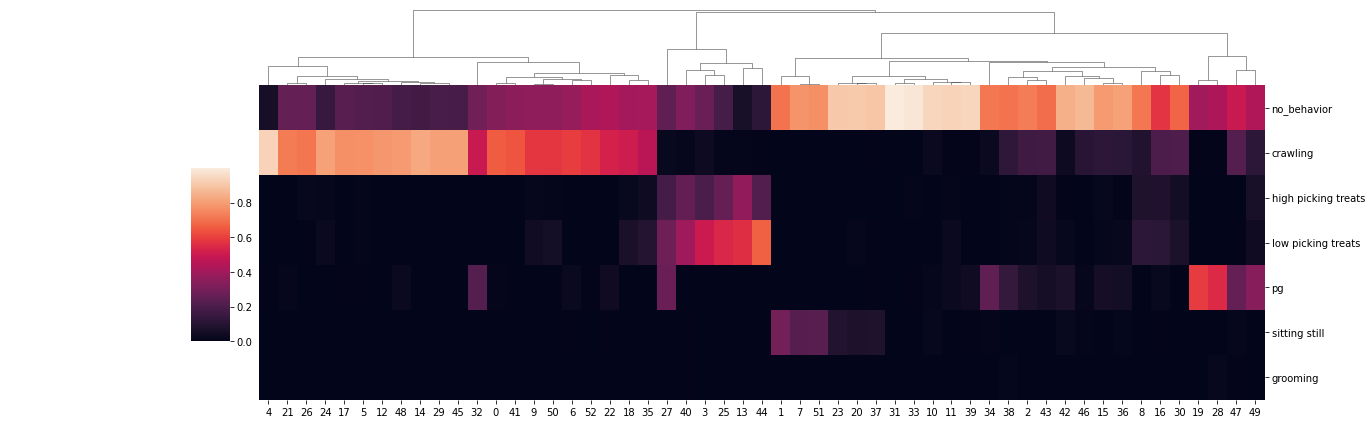

In [349]:
plot_confusion_matrix(y_all, gmm_labels_meanz8, bhvs.keys(), figsize = (18,6), sum_by = 'col')

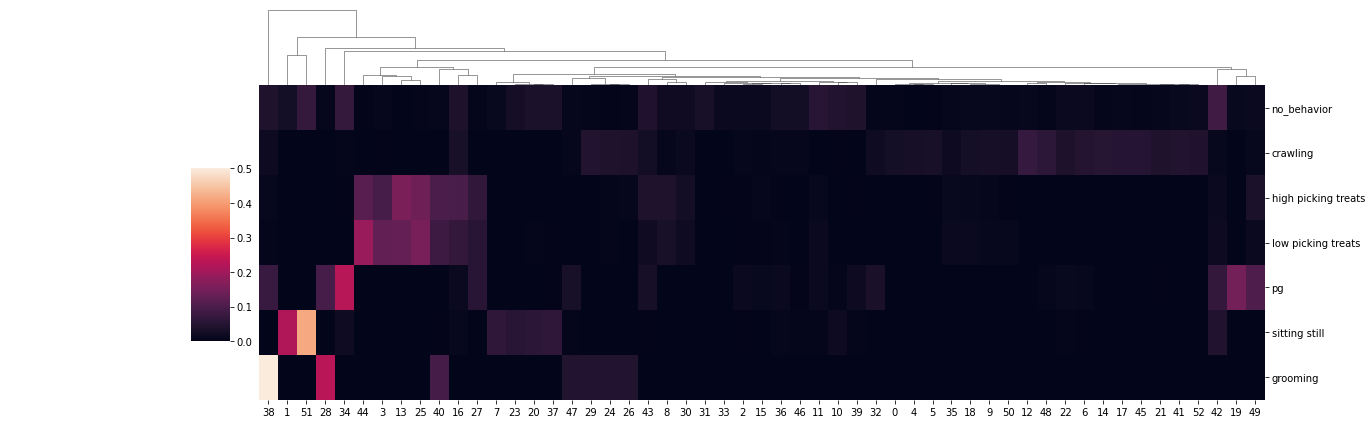

In [350]:
plot_confusion_matrix(y_all, gmm_labels_meanz8, bhvs.keys(), figsize = (18,6), sum_by = 'row')

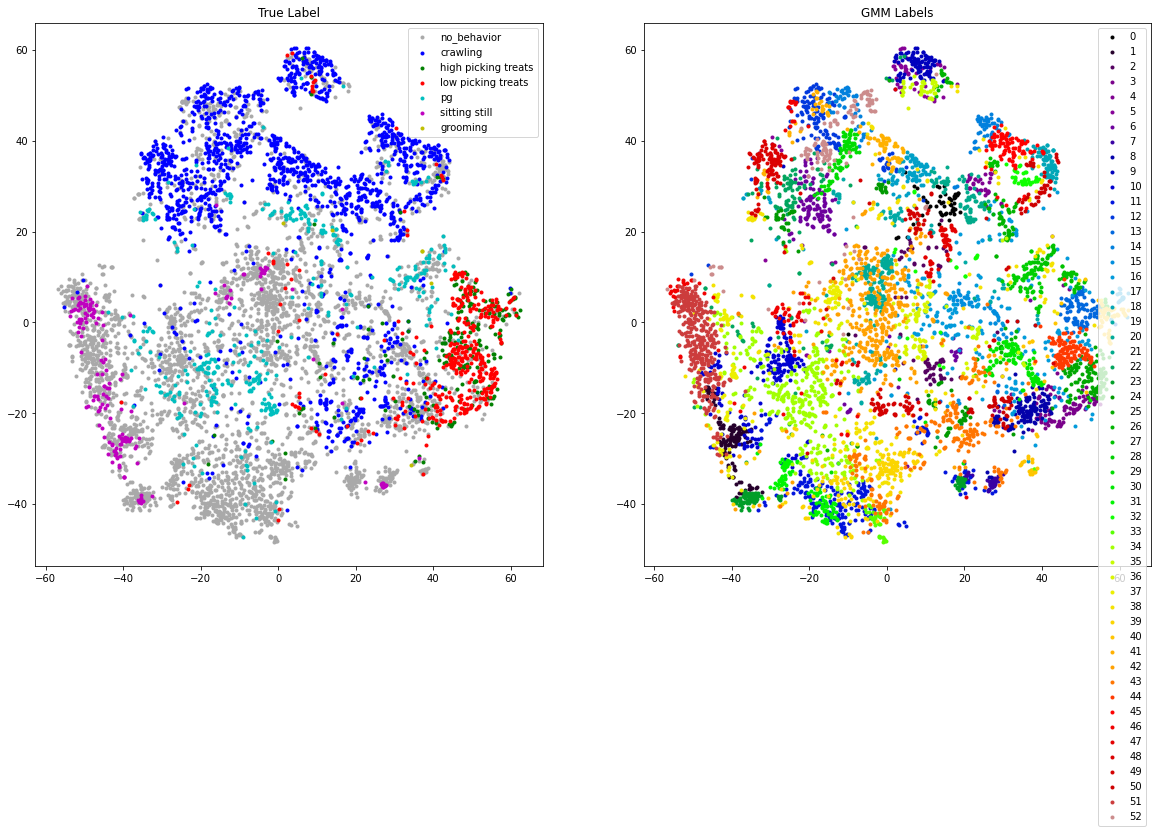

In [351]:
compare_label_tSNE(z_run, y_all, inv_bhvs, 'True Label', gmm_labels_meanz8, None, 'GMM Labels',
                       one_in = 4, perplexity=80, n_iter=3000)

### Save to annot file

In [748]:
# all_length = [0, 3599, 3599, 3599, 3601, 3599, 3599, 3588]
all_length = [0, 1800, 1800, 1800, 1801, 1800, 1800, 1794]

seg = np.cumsum(all_length)
seg

array([    0,  1800,  3600,  5400,  7201,  9001, 10801, 12595])

In [749]:
annot_label = infomap_label

all_label = annot_label.reshape(annot_label.shape[0])

seg_label = []
seg_label_half = []

for ii in range(7):
    seg_label.append(all_label[seg[ii]: seg[ii+1]])

for jj in seg_label:
    print(len(jj))
    
for jj in seg_label:
#     jj = jj[::2] # if the annot_label is the repeated version
    jj = np.repeat(jj, 15) # EMG is 20 fps, video is 30
    seg_label_half.append(jj)

for jj in seg_label_half:
    print(np.unique(jj), len(jj))

1800
1800
1800
1801
1800
1800
1794
[0 1 2 3 4] 27000
[0 1 2 3 4] 27000
[0 1 2 3 4] 27000
[0 1 2 3 4] 27015
[0 1 2 3 4] 27000
[0 1 2 3 4] 27000
[0 1 2 3 4] 26910


In [379]:
for ii in range():
    print(f'\'cluster{ii}\', ' , end = '')

'cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8', 'cluster9', 'cluster10', 'cluster11', 'cluster12', 'cluster13', 'cluster14', 'cluster15', 'cluster16', 'cluster17', 'cluster18', 'cluster19', 

In [750]:
beh_list = ['Resting 1', 'Crawling', 'Reaching', 'Resting 2a', 'Resting 2b']

In [751]:
all_moviename =['Pop_20201020_cage_C3_01.avi', 'Pop_20201020_cage_C3_02.avi', 'Pop_20201020_cage_C3_03.avi', 'Pop_20201020_cage_C3_04.avi', 'Pop_20201020_cage_C3_05.avi', 'Pop_20201020_cage_C3_06.avi', 'Pop_20201020_cage_C3_07.avi']

In [752]:
from collections import Counter

for ii in range(7):
#     start = time[ii]
#     end = time[ii+1]
            
    curr_label = seg_label_half[ii]
#     print(Counter(curr_label))
#     curr_label = np.repeat(curr_label, 10)
    filename = '/home/roton2/ruize/annotation/im_label-final_'+all_moviename[ii][:-4]+'.annot'
    dump_labels_bento(curr_label, filename, all_moviename[ii], 30, beh_list)

### Transition matrix

In [730]:
with open(dload+'/infomap_community', 'wb') as fh:
    pickle.dump([y_all_half, z_run_half, merged_labels_half, infomap_label, M1, order2, im_dict], fh)

In [756]:
# Get the first set of labels from merged_label, and from true label y_all
# And get the non-overlapping points in latent space z_run and original data X_all

merged_labels_half = [ j for i in seg_label_half for j in i]
merged_labels_half = np.array(merged_labels_half[::15])
print(np.unique(merged_labels_half))

all_length = [0, 3599, 3599, 3599, 3601, 3599, 3599, 3588]
seg = np.cumsum(all_length)
X_all_half = []
y_all_half = []
z_run_half = []
for ii in range(7):
    temp1 = y_all[seg[ii]: seg[ii+1]][::2]
    y_all_half.append(temp1)
    temp2 = z_run[seg[ii]: seg[ii+1], :][::2, :]
    z_run_half.append(temp2)
    temp3 = X_all[seg[ii]: seg[ii+1], :, :][::2, :, :]
    X_all_half.append(temp3)

y_all_half = np.concatenate(y_all_half, axis = 0)
z_run_half = np.concatenate(z_run_half, axis = 0)
X_all_half = np.concatenate(X_all_half, axis = 0)
print(y_all_half.shape, z_run_half.shape, X_all_half.shape)

[0 1 2 3 4]
(12595, 1) (12595, 8) (12595, 10, 15)


In [11]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

In [729]:
# Show transition matrix

M1 = transition_matrix(merged_labels_half)
M1 = np.array(M1)
plt.matshow(M1)

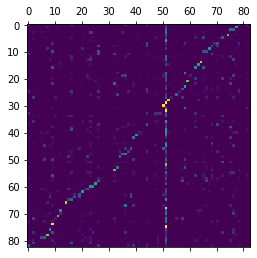

In [717]:
# Sorted by prob

prob = np.argmax(M1, axis = 0)
idx = np.argsort(prob)
plt.matshow(M1[:, idx][:, ::-1])

In [718]:
from infomap import Infomap

adj_matrix = M1

# Command line flags can be added as a string to Infomap
im = Infomap(include_self_links=True, silent=True, no_file_output=True, directed=True, weight_threshold = 0,
            preferred_number_of_modules = 5)

for ii in range(adj_matrix.shape[0]):
    for jj in range(adj_matrix.shape[0]):
#         if adj_matrix[ii,jj] != 0:
        im.add_link(ii, jj, adj_matrix[ii,jj])

# Run the Infomap search algorithm to find optimal modules
im.run()

print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

im_dict = {}
order2 = []
print("Result")
print("\n#node module")
nn=0
for node in im.tree:
    if node.is_leaf:
        nn+=1
        order2.append(node.node_id)
        im_dict[node.node_id] = node.module_id-1
        print(node.node_id, node.module_id)
print(nn)

Found 5 modules with codelength: 4.185160998287218
Result

#node module
6 1
68 1
12 1
52 1
41 1
26 1
81 1
31 1
18 1
53 1
23 1
79 1
39 1
36 1
45 1
40 1
29 1
50 1
32 1
75 1
34 2
51 2
11 2
25 2
47 2
8 2
61 2
49 2
5 2
73 2
56 2
82 2
20 2
37 2
24 2
58 2
44 2
38 2
22 2
57 2
42 2
80 2
54 2
27 2
72 2
7 2
77 2
33 2
0 2
65 2
10 2
16 2
74 2
46 3
67 3
63 3
64 3
70 3
55 3
76 3
48 3
13 3
3 3
19 3
2 3
30 3
60 3
62 4
9 4
78 4
1 4
71 4
66 4
43 4
21 5
59 5
35 5
15 5
69 5
28 5
4 5
17 5
14 5
83


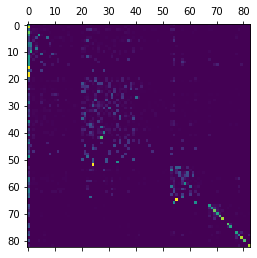

In [735]:
x_sorted2 = adj_matrix[:, order2]
x_sorted2 = x_sorted2[order2, :]
plt.matshow(x_sorted2)

In [726]:
infomap_label = []
for ii in half_label:
    if ii in im_dict.keys():
        infomap_label.append(im_dict[ii])
    else:
        infomap_label.append(-1)

prev = object()
infomap_label_norepeat = [prev:=v for v in infomap_label if prev!=v]
infomap_label = np.array(infomap_label)
infomap_label_norepeat = np.array(infomap_label_norepeat)

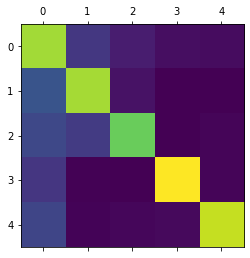

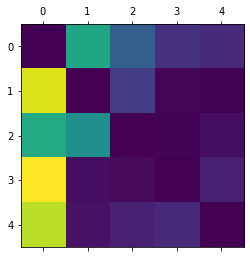

In [727]:
M_infomap = transition_matrix(infomap_label)
M_infomap = np.array(M_infomap)
M_infomap_norepeat = transition_matrix(infomap_label_norepeat)
M_infomap_norepeat = np.array(M_infomap_norepeat)
plt.matshow(M_infomap)
plt.matshow(M_infomap_norepeat)

In [753]:
infomap_bhvs = {0: 'Resting 1', 1: 'Crawling', 2: 'Reaching', 3: 'Resting 2a', 4: 'Resting 2b'}

In [754]:
compare_label_tSNE(z_run_half, y_all_half, inv_bhvs, 'True Label', infomap_label, infomap_bhvs, 'Infomap Labels',
                       one_in = 1, perplexity=80, n_iter=3000)

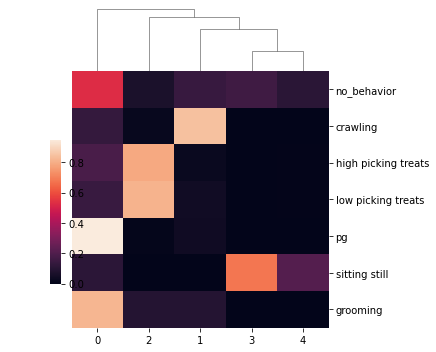

In [739]:
plot_confusion_matrix(y_all_half, infomap_label, bhvs.keys(), figsize = (5,5), sum_by='row')

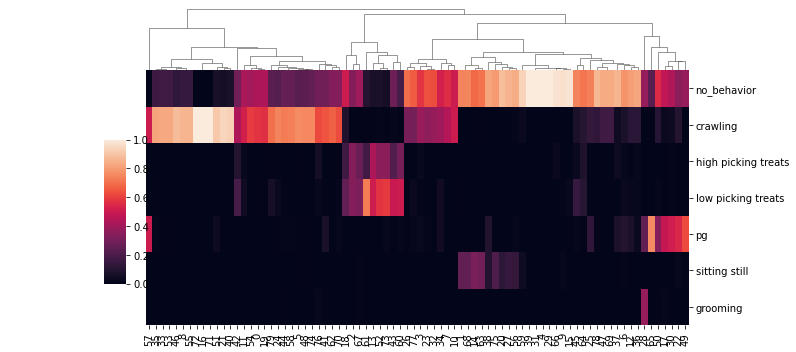

In [741]:
plot_confusion_matrix(y_all_half, merged_labels_half, bhvs.keys(), figsize = (10,5), sum_by='col')

### Plot trace in each cluster

In [768]:
loc = (infomap_label == 1).flatten()
trial = X_all_half[loc, :, :]
average_value = np.mean(trial, axis=(0))
print(sum(loc), trial.shape, average_value2.shape)

3624 (3624, 10, 15) (10, 15)


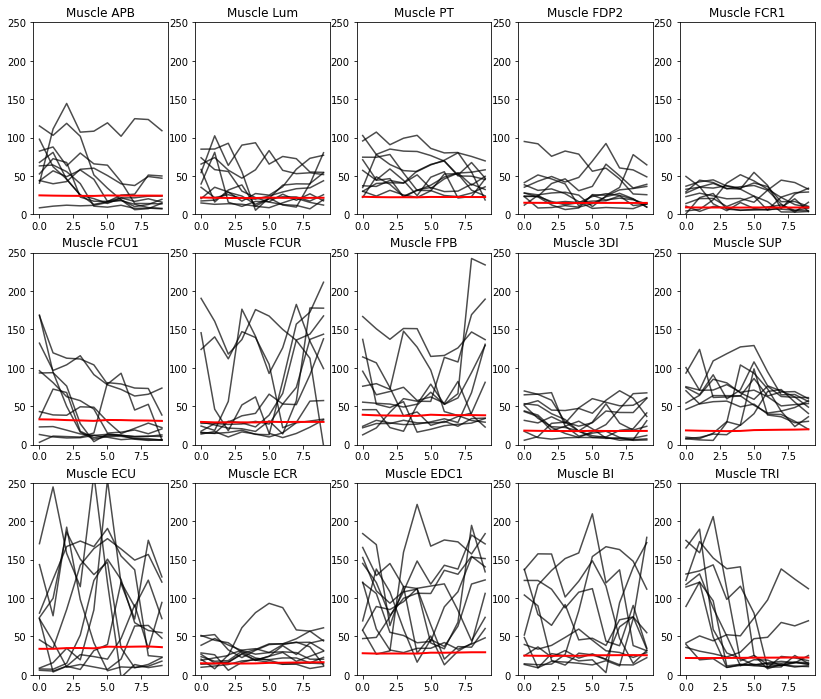

In [782]:
muscles = ['APB', 'Lum', 'PT', 'FDP2', 'FCR1', 'FCU1', 'FCUR', 'FPB', '3DI', 'SUP', 'ECU', 'ECR', 'EDC1', 'BI', 'TRI']

fig, axs = plt.subplots(3,5, figsize = (14, 12))
for ii in range(15):
    mean = average_value2[:, ii]
    for jj in range(10):
        nn = np.random.randint(trial.shape[0], size=1)[0]
        
        trial_random = trial[nn,:, ii]
        axs[ii//5, ii%5].plot(trial_random, color = 'black', label = 'Single seq', alpha = 0.7)
    axs[ii//5, ii%5].plot(mean, color = 'red', label = 'Average', linewidth=2)
    axs[ii//5, ii%5].set_title(f'Muscle {muscles[ii]}')
    axs[ii//5, ii%5].set_ylim([0, 250])
# plt.suptitle('Example trace in cluster Crawling')
plt.show()

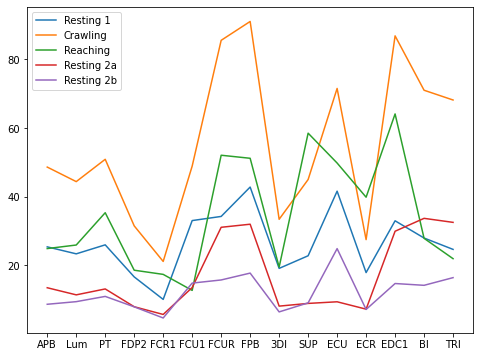

In [785]:
labels=['Resting 1', 'Crawling', 'Reaching', 'Resting 2a', 'Resting 2b']
muscles = ['APB', 'Lum', 'PT', 'FDP2', 'FCR1', 'FCU1', 'FCUR', 'FPB', '3DI', 'SUP', 'ECU', 'ECR', 'EDC1', 'BI', 'TRI']

mean_all = []
error_all = []

for ii in range(5):
    loc = (infomap_label == ii).flatten()
    trial = X_all_half[loc, :, :]
    mean = np.mean(trial, axis=(0,1))
    error = np.std(trial, axis=(0,1))
    mean_all.append(mean)
    error_all.append(error)

plt.figure(figsize=(8,6))
for ii in range(5):
#     plt.errorbar(list(range(1, 16)), mean_all[ii], yerr = error_all[ii], label = ii)
    plt.plot(list(range(1, 16)), mean_all[ii], label = labels[ii])
plt.xticks(list(range(1, 16)), labels = muscles)
plt.legend()
